Data Focused Python  
Final Project  
name  
May 7, 2018  

## Part 1 Extracting data
We extracted product data such as product name, price, and customer ratings from eBay, Walmart, and Flipkart. Methods to extract data are web scraping and web API.  
(Note: Amazon does not seem to permit to scrape nor to offer star ratings by API. For this reason, we did not choose Amazon in this project.)

### (1) Extracting data from eBay by web scraping
We first identified the number of results which was displayed at the top of a search result page. Then, we calculated number of pages so that we could access every result page. (Since 50 items are displayed per page, we can solve for the number of pages by dividing the number of items hit by 50.)  
In each page, we extracted 'list' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table').  
Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [85]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time
import math
import pandas as pd

In [86]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [124]:
search_word = "Samsung phones"
payload = {'_nkw':search_word}
    
r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
page = r.content
soup = bs(page, "html.parser")

# Count the number of pages of the search result
num_items = soup.find_all("span", class_ = "rcnt")
num_items = get_text_from_elements(num_items)
num_items = int(num_items[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer

items_per_page = 50
link_pages = int(math.ceil(num_items / items_per_page))

print("The number of items hit by the search is", num_items)
print("The number of pages is", link_pages)

The number of items hit by the search is 58270
The number of pages is 1166


In [125]:
# Scrape the data from each search result page using for loop (this may take much time)

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 100))): # to avoid kernel dead, limit maximum pages (100 items * 50 pages)
    page_num = i + 1
    payload = {'_nkw':search_word, '_pgn': page_num}
    r = requests.get('https://www.ebay.com/sch/i.html', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data and store in a list of "products"
    result_items = soup.find_all('div', id = "ResultSetItems")
    r_lists = range(2, items_per_page + 1)
    products = result_items[0].find_all("li", r = "1")
    for r_list in r_lists:
        product = result_items[0].find_all("li", r = str(r_list))[0] # To make class bs4.element.ResultSet into bs4.element.Tag
        products.append(product)

    
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "star-ratings")) != 0:
            # Get review rating data
            review = float(product.find('div', class_ = "star-ratings").find("a")["aria-label"].split(" ")[1])
            # Get title data
            title = product.find('h3', class_ = "lvtitle").find("a").text
            # Get Price data
            price = float(product.find('li', class_ = "lvprice prc").find("span").text.split("$")[-1].replace(",",""))
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)

            
#print(products_table) # you can print the list by this line
print("The number of obtained products is", len(products_table))

The number of obtained products is 3082


In [126]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 2269 out of 3082


In [127]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw data
products_table_df

,Name,Ratings,Price
0,Samsung Galaxy S7 SM-G930 - 32GB - Gold Platin...,4.41,259.90
1,Factory Unlocked Samsung Galaxy S7 Edge GSM LT...,4.50,399.99
2,Samsung Galaxy S7 edge G935V 32GB Verizon AT&T...,4.69,199.99
3,Samsung Galaxy S5 S4 - Factory Unlocked - GSM ...,4.13,168.99
4,"Samsung Galaxy S8 64GB 5.8"" Display AT&T Unloc...",4.95,564.99
5,"Samsung Galaxy S7 edge 32GB 5.5"" G935 4G LTE G...",5.00,224.99
6,\r\n\t\t\t\tSamsung Galaxy S7 32GB SM-G930T Un...,4.60,169.99
7,NEW Samsung Galaxy Note 4 SM-N910A AT&T UNLOCK...,4.42,209.88
8,Samsung Galaxy S7 G930V 32GB AT&T T-Mobile Ver...,4.60,174.97
9,\r\n\t\t\t\tSamsung Galaxy S8+ Plus / S8 64GB ...,4.76,482.40


In [128]:
# Output to CSV file as raw data
products_table_df.to_csv("ebay_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted some special characters including '\r', '\n', and '\t'
- Sorted by product name

In [129]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Delele "'\r', '\n', '\t'" from Name column
products_table_df2.loc[:, "Name"] = [name.replace("\t", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\r", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("\n", "") for name in products_table_df2["Name"]]
products_table_df2.loc[:, "Name"] = [name.replace("!!", "") for name in products_table_df2["Name"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\hika1\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [130]:
# Print the processed data
products_table_df2

,Name,Ratings,Price
0,"""NEW"" Samsung Galaxy Note 4 SM-N910A AT&T UNLO...",4.35,169.88
1,"""NEW"" Samsung Galaxy S6 SM - G920A - 32GB - Go...",4.62,189.99
2,"""NEW"" Samsung Galaxy S7 Edge SM-G935A AT&T Unl...",4.69,319.88
3,"""New"" Samsung Galaxy Note 4 SM-N910V Verizon U...",5.00,169.95
4,"""New"" Samsung Galaxy Note 5 Verizon Wireless U...",5.00,224.95
5,"""New"" Samsung Galaxy S5 SM-G900A AT&T- GSM Unl...",4.38,124.95
6,"""New-Other"" Samsung Galaxy S7 Edge 32gb G935V ...",4.86,259.01
7,*** New Samsung Galaxy S7 SM-G930 - 32GB - Bla...,4.70,294.95
8,*** New Unlocked Verizon Samsung Galaxy S7 SM-...,4.65,284.95
9,*Brand - New - Samsung J3 Eclipse SM-J327V - 1...,5.00,109.99


In [131]:
# Output to CSV file as processed data
products_table_df2.to_csv("ebay_clean.csv")

### (2) Extracting data from Walmart by web API
To diversify methods of acquiring data, we decided to extract Walmart's data using web API. First, we registered Walmart Open API (Product Lookup API), then read the API documents through to understand query parameters and the structure of response. Next, we set query parameters regarding number of items obtained per request (as 25 items) and staring point of each request, then got JSON files for each request. Using for loop, we iterated collecting JSON data 40 times so that we could acquire 1,000 items in total. This is because Walmart Open API offers up to only 1,000 items per keyword. After that, I converted the JSON data into Pandas data frame consisting of product name, price, and customer ratings ('product_table').  
We found that extracting data by web API is relatively easier than by web scraping, although it took several hour to understand how to sign up Walmart Open API and how to use it to obtain product data.

In [132]:
import requests
import pandas as pd

In [133]:
# Determine a search word
search_word = "Samsung phones"

# Create a new list to store product information
product_table = pd.DataFrame()

In [134]:
# Extract data of 1000(=25*40) items (1st-1000th item)
# According to the Walmart API documentation, "Pagination is limited to the top 1000 items for a particular search." 
for i in range(40):
    payload = {'apiKey':'t5f6xrjyupatsqspx28aprtj', 'query':search_word, 'numItems':'25', 'start':str(25*i+1)}
    r = requests.get('http://api.walmartlabs.com/v1/search', params = payload)
    data = r.json()
    items = pd.DataFrame(data["items"], columns=['name', 'salePrice','customerRating'])
    product_table = product_table.append(items, ignore_index = True)
print(len(product_table),"products obtained from total results of", data["totalResults"], "by this code ")

968 products obtained from total results of 409775 by this code 


In [135]:
# Print the raw data
product_table

,name,salePrice,customerRating
0,Straight Talk Samsung Galaxy J3 Luna Pro 16GB ...,59.99,3.941
1,Total Wireless Samsung Galaxy J3 Luna Pro 16GB...,79.99,3.539
2,AT PREPAID Samsung Galaxy Express Prime 2 16GB...,99.00,4.046
3,Straight Talk Samsung Galaxy J7 Sky Pro 16GB P...,149.99,4.441
4,Straight Talk Samsung Galaxy J1 Luna 8GB Prepa...,29.99,2.49
5,Walmart Family Mobile Samsung S337 Luna Pro 16...,79.99,3.286
6,Total Wireless Samsung J7 Sky Pro 16GB Prepaid...,149.99,4.875
7,Samsung Galaxy J2 Prime G532M 16GB Unlocked GS...,106.97,NaN
8,Cricket Wireless Samsung Galaxy Sol 2 16GB Pre...,99.99,NaN
9,Boost Mobile Samsung J3 Emerge 16GB Prepaid Sm...,69.99,4.259


In [136]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in product_table['name']:
    if product not in product_name:
        product_name[product] = 1
    else:
        product_name[product] += 1   
print("# of unique products is", len(product_name), "out of", len(product_table['name']))

# of unique products is 743 out of 968


In [137]:
# Output to CSV file as raw data
product_table.to_csv("walmart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted rows with null data
- Sorted by product name

In [138]:
# Data Cleaning
# Change the column names
product_table.columns = ["Name", "Price", "Ratings"]

# Change the order of the columns
product_table2 = product_table.loc[:,["Name", "Ratings", "Price"]]

# Remove duplicated products
product_table2 = product_table2.drop_duplicates("Name")

# Drop rows containing null data
product_table2 = product_table2.dropna()

# Sort by product name and reset index
product_table2 = product_table2.sort_values(by="Name")
product_table2 = product_table2.reset_index(drop=True)

In [139]:
# Print the processed data
product_table2

,Name,Ratings,Price
0,"""Acuvar 6.5"""" inch Flexible Tripod With Univer...",4.68,5.99
1,"""Insten Black Waterproof Bag Carrying Case Pou...",4.5,2.39
2,"""New Galaxy S6 Edge Plus 32GB G928A by Samsung...",5.0,369.95
3,"""New J7 Pro 2017 32GB J730GM/DS by Samsung GSM...",4.0,267.95
4,"""Samsung Galaxy Tab A 7.0"""" LTE Tablet (Factor...",4.5,185.95
5,"""Value Pack + for 5.5"""" Samsung Galaxy J7 2017...",4.0,11.99
6,"""Value Pack for 5.5"""" Samsung Galaxy J7 2017 S...",5.0,10.99
7,"""for 5.5"""" Samsung Galaxy J7 2017 sky pro J730...",3.0,8.99
8,100% FREE MOBILE PHONE SVC W/ FREEDOMPOP SAMSU...,2.077,195.43
9,A1 Bluetooth Smart Watch Phone GSM for Android...,2.667,16.99


In [140]:
# Output to CSV file as processed data
product_table2.to_csv("walmart_clean.csv")

### (3) Extracting data from Flipkart by web scraping
We first identified the number of result pages which was displayed at the bottom of a search result page. Then, we set queries of page number as well as the search word, and did loop processing to access to all the page of seach results. In each page, we extracted 'div' tags containing star-ratings, title, and price information of a product, and stored them in to a list ('products_table'). One thing that we got confused was that the attribute of the 'div' tags was different among product categories. Thus, it took us some time to examine HTML source whenever we tried to change search keywords. Finally, we converted the list into Pandas data frame of product name, price, and customer ratings obtained ('products_table_df').

In [141]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time

In [142]:
# Cited from lab 3
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

In [143]:
search_word = "Samsung phones"
#payload = {'q':search_word}
payload = {"page": 1, 'q':search_word, 'viewType':'list'}

r = requests.get('http://www.flipkart.com/search', params = payload)
page = r.content
soup = bs(page, "html.parser")

In [144]:
# Count the number of pages of the search result
link_pages = soup.find_all("span", class_ = "_3v8VuN")
link_pages = get_text_from_elements(link_pages)
# To split the string like 'Page 3 of 26' by space, extract a row from the list of one row ('link_pages')
if link_pages == []:
    link_pages = 1
else:
    link_pages = link_pages[0].split(" ")
    link_pages = int(link_pages[-1].replace(",","")) # replace "1,234" into "1234" and convert into integer
print("The number of pages is", link_pages)

The number of pages is 13


In [145]:
# Scrape the data from each search result page using for loop

# Create empty lists
products_table = []

# For each search result page, get all the review rating, title, and price data
for i, page in enumerate(range(min(link_pages, 50))): # to avoid kernel dead, limit maximum pages (40 items * 50 pages)
    page_num = i + 1
    payload = {"page": page_num, 'q':search_word, 'viewType':'list'}
    r = requests.get('http://www.flipkart.com/search', params = payload)
    page = r.content
    soup = bs(page, "html.parser")

    # Get product data (eliminating recently reviewed items and recommended items)
#    products = soup.find_all('div', class_ = "MP_3W3 _31eJXZ") if you search toys, use this line
    products = soup.find_all('div', class_ = "_1-2Iqu row") # if you search electronics such as laptops, use this line
    for product in products:
        # Remove products which have not review ratings
        if len(product.find_all("div", class_ = "hGSR34 _2beYZw")) != 0:
            # Get review rating data
            review_element = product.find_all("div", class_ = "hGSR34 _2beYZw")
            review_text = review_element[0].text
            review = review_text.split(" ")[0]
            review = float(review)
            # Get title data
#            title = product.find_all("a", class_ = "_2cLu-l")[0].text # if you search toys, use this line
            title = product.find_all("div", class_ = "_3wU53n")[0].text # if you search electronics such as laptops, use this line
            # Get Price data
            price = product.find_all("div", class_ = "_1vC4OE")[0].text
            # Merge the data
            product_table = [title, review, price]
            # Mutate the data table
            products_table.append(product_table)
    
#print(products_table) # You can print the list by this line
print("The number of products is", len(products_table))

The number of products is 276


In [146]:
# Uniqueness check using 'dict'
product_name = {}
count = 0
for product in products_table:
    if product[0] not in product_name:
        product_name[product[0]] = 1
    else:
        product_name[product[0]] += 1   
print("The number of unique products is", len(product_name), "out of", len(products_table))

The number of unique products is 245 out of 276


In [147]:
# Convert into Pandas Data frame
import pandas as pd
products_table_df = pd.DataFrame(products_table, columns = ["Name", "Ratings", "Price"])
# Print the raw table
products_table_df

,Name,Ratings,Price
0,"Samsung Galaxy On Max (Gold, 32 GB)",4.3,"₹13,900"
1,"Samsung Galaxy On Nxt (Gold, 64 GB)",4.2,"₹12,900"
2,"Samsung Galaxy On Max (Black, 32 GB)",4.3,"₹13,900"
3,"Samsung Galaxy J3 Pro (Gold, 16 GB)",4.2,"₹7,490"
4,"Samsung Galaxy On Nxt (Black, 64 GB)",4.2,"₹12,900"
5,"Samsung Galaxy On5 (Gold, 8 GB)",4.2,"₹6,990"
6,"Samsung Galaxy On Nxt (Gold, 16 GB)",4.2,"₹10,999"
7,"Samsung Galaxy On Nxt (Black, 16 GB)",4.2,"₹10,999"
8,"Samsung J7 Max (Gold, 32 GB)",4.3,"₹14,900"
9,"Samsung Galaxy J7 Nxt (Gold, 16 GB)",4.3,"₹9,490"


In [148]:
# Output to CSV file as raw data
products_table_df.to_csv("flipkart_raw.csv")

After we obtained the product data table, we cleaned the data as follows:
- Removed duplicated products
- Deleted Indian Rupee mark from Price
- Sorted by product name

In [149]:
# Data Cleaning
# Remove duplicated products
products_table_df2 = products_table_df.drop_duplicates("Name")

# Eliminate "₹" (Indian Rupee mark from Price) 
products_table_df2.loc[:, "Price"] = [int(price[1:].replace(",", "")) for price in products_table_df2["Price"]]

# Sort by product name and reset index
products_table_df2 = products_table_df2.sort_values(by="Name")
products_table_df2 = products_table_df2.reset_index(drop=True)

C:\Users\hika1\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [150]:
# Print the processed table
products_table_df2

,Name,Ratings,Price
0,Samsung B350,4.0,2580
1,Samsung B351E/Metro 350,4.1,2800
2,Samsung E1207 Guru FM Dual Sim - Blue,3.3,1499
3,Samsung GT 1200 R/I/M,4.0,1282
4,"Samsung Galaxy A3 (Champagne Gold, 16 GB)",4.0,7800
5,"Samsung Galaxy A3 (Pearl White, 16 GB)",4.0,8500
6,"Samsung Galaxy A5 (Black, 16 GB)",4.1,14490
7,"Samsung Galaxy A5 (Champagne Gold, 16 GB)",4.1,11900
8,"Samsung Galaxy A5 (Midnight Black, 16 GB)",4.1,15948
9,"Samsung Galaxy A5 (Pearl White, 16 GB)",4.1,15993


In [151]:
# Output to CSV file as processed data
products_table_df2.to_csv("flipkart_clean.csv")

## Part 2 Merging the data
We developed algorithm to merge the data from three sources. This algorithm was implemented in another tool Alteryx.

In [1]:
import pandas as pd

# Read the three processed data from each csv file and store in each data frame
ebay_data = pd.read_csv("ebay_clean.csv", index_col = 0)
walmart_data = pd.read_csv("walmart_clean.csv", index_col = 0)
flipkart_data = pd.read_csv("flipkart_clean.csv", index_col = 0)

### (1) Outer Join of eBay data and Walmart data

### (2) Left Join of the merged data and Flipkart data

## Part 3 Visualizing the data

### (1) Pre-merged data
First, we explored pre-merged data to search for any interesting findigs. The outputs of the exploration are as follows.

In [18]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
import matplotlib
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

# Read the three processed data from each csv file and store in each data frame
ebay_data = pd.read_csv("ebay_clean.csv", index_col = 0)
walmart_data = pd.read_csv("walmart_clean.csv", index_col = 0)
flipkart_data = pd.read_csv("flipkart_clean.csv", index_col = 0)
merged_data = pd.read_csv("merged.csv", index_col = 0)

The descriptive statistics of product ("Samsung phones") data on eBay is as follows. We can see that the mean ratings is 4.56, which is relatively high. Thus, eBay users might tend to rate items high.

In [16]:
ebay_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,2269.000000,2269.000000
mean,4.563407,198.231247
std,0.270982,147.758502
min,1.000000,0.010000
25%,4.480000,99.990000
50%,4.570000,169.990000
75%,4.670000,239.950000
max,5.000000,1000.000000


Below is the descriptive statistics of product ("Samsung phones") data on Walmart. Contrary to eBay, Walmart users migit tend to rate items low because the mean ratings is 3.81. However, its standard devieation is much higher than eBay. This implies that Walmart sells both products with very high ratings and products with very low ratings.  
Also, the mean price (in US dollar) of Walmart is lower than that of eBay. This implies that Walmart sells cheaper products than eBay, or many relatively irrelevant cheaper items (such as Samsung phone cases or holders) were just hit by search.

In [17]:
walmart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,196.000000,196.000000
mean,3.817847,109.628673
std,1.097097,185.376700
min,1.000000,1.790000
25%,3.209000,8.990000
50%,4.000000,16.980000
75%,4.732750,129.990000
max,5.000000,918.740000


The descriptive statistics of product ("Samsung phones") data on Flipkart is as follows. We can see that the mean ratings is 4.08 and the standard deviation is as large as that of eBay. Since 1 (one) US dollar equals to approximately 67 Indian rupees, the mean price is almost the same value as 250 US dollars, which is relatively high. 

In [15]:
flipkart_data[["Ratings", "Price"]].describe()

,Ratings,Price
count,245.000000,245.000000
mean,4.077959,18429.738776
std,0.294352,15424.926670
min,3.000000,1076.000000
25%,4.000000,7490.000000
50%,4.100000,13400.000000
75%,4.200000,25900.000000
max,4.700000,74900.000000


The following plot show the relationship between price and customer ratings of items on eBay. This plot shows that most items are rated high and that there are no expensive items that have lower ratings.  
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on eBay')

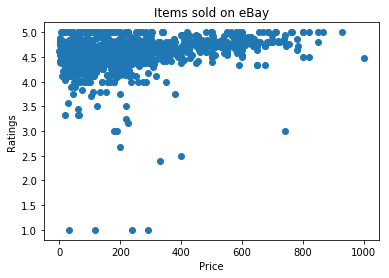

In [44]:
plt.plot(ebay_data["Price"], ebay_data["Ratings"], "o")
#plt.semilogx(ebay_data["Price"], ebay_data["Ratings"], "o")
#plt.loglog(ebay_data["Price"], ebay_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on eBay")

The following plot show the relationship between price and customer ratings of items on Walmart. This plot indicates that there might be a weak linear positive relationship between price and ratings. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Walmart')

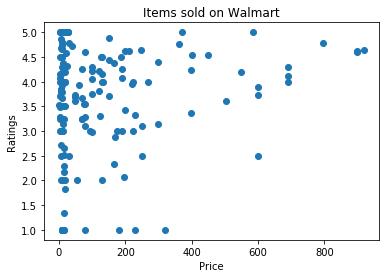

In [42]:
plt.plot(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.semilogx(walmart_data["Price"], walmart_data["Ratings"], "o")
#plt.loglog(walmart_data["Price"], walmart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Walmart")

The following plot show the relationship between price and customer ratings of items on Flipkart. This plot demonstrates that there might be a weak linear positive relationship between price and ratings, but customer ratings appear to be discrete. Also, we can say that there are no expensive items that have lower ratings, too.   
We also tried log-level plot and log-log prot, but we could not obtain meaningful results.

Text(0.5,1,'Items sold on Flipkart')

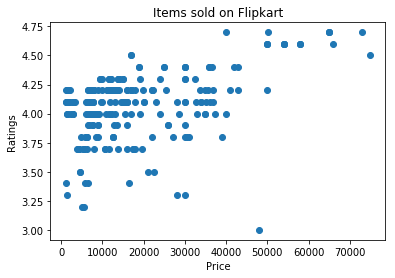

In [40]:
plt.plot(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.semilogx(flipkart_data["Price"], flipkart_data["Ratings"], "o")
#plt.loglog(flipkart_data["Price"], flipkart_data["Ratings"], "o")

plt.xlabel("Price")
plt.ylabel("Ratings")
plt.title("Items sold on Flipkart")

### (2) Merged data
Next, we explored the merged data.

### References
- Achin Sagar, "Extracting Flipkart reviews through web scraping", Quora, accessed April 8, 2018, https://codeexperiments.quora.com/Extracting-Flipkart-reviews-through-web-scraping
- Search API, "Walmart Open API", https://developer.walmartlabs.com/docs/read/Search_API